## This Notebook prepares the data on state aid

Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

The data on state aid is downloaded from: https://webgate.ec.europa.eu/competition/transparency/public?lang=en

The CSV Files are stored in 'data/raw'

In [ ]:
path = r'/Users/marco/Library/CloudStorage/OneDrive-HertieSchool/Thesis/GitHub/thesis/data/raw' 
all_files = glob.glob(os.path.join(path , "*.csv"))

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

Filter for Germany

In [3]:
frame = frame[(frame.Land == 'Deutschland')]
frame.shape

(155516, 25)

Filter for State Aid that is related to the pandemic

In [4]:
frame = frame[(frame['Ziel der Beihilfe'] == 'Behebung einer beträchtlichen Störung im Wirtschaftsleben eines Mitgliedstaats') ]
frame.shape

(135478, 25)

Store complete data set as 'all_companies.csv'

In [15]:
frame.to_csv(r'/Users/marco/Library/CloudStorage/OneDrive-HertieSchool/Thesis/GitHub/thesis/data/main/all_companies.csv', index=False, header=True)

Store only companies as 'companies.csv'

In [ ]:
frame = frame[['Name des Beihilfeempfängers','Nationale Kennung']].drop_duplicates()
frame = frame.reset_index(drop=True, names='index')
frame.index = frame.index.rename('Index')
frame['Status'] = ''
frame
frame.to_csv(r'/Users/marco/Library/CloudStorage/OneDrive-HertieSchool/Thesis/GitHub/thesis/data/main/companies.csv', sep='$' , index=True, header=True)

## Data insights

Show column names

In [5]:
list(frame.columns)

['Land',
 'Begünstigter in anderem Mitgliedstaat',
 'Titel der Beihilfemaßnahme',
 'Titel der Beihilfemaßnahme [EN]',
 'SA.Nummer',
 'Kennung',
 'Nationale Kennung',
 'Name des Beihilfeempfängers',
 'Name des Beihilfeempfängers [EN]',
 'Art des Beihilfeempfängers',
 'Region',
 'Wirtschaftszweig (NACE)',
 'Beihilfeinstrument',
 'Beihilfeinstrument [EN]',
 'Ziel der Beihilfe',
 'Ziel der Beihilfe [EN]',
 'Nominalbetrag',
 'Beihilfeelement, in voller Höhe',
 'Währung',
 'Tag der Gewährung',
 'Name der Bewilligungsbehörde',
 'Name der Bewilligungsbehörde [EN]',
 'Veröffentlicht am',
 'Betraute Einrichtung',
 'Finanzintermediäre']

Show aid instruments

In [6]:
frame.groupby('Beihilfeinstrument').count()['Land'].sort_values(ascending=False)

Beihilfeinstrument
Zuschuss                                 76484
Sonstiges (bitte angeben)                36127
Zinsgünstiges Darlehen                   19920
Zinszuschuss                              2191
Andere Formen der Kapitalintervention      567
Bürgschaft                                 175
Eigenkapitalinstrumente                      8
Kredite/rückzahlbare Vorschüsse              6
Name: Land, dtype: int64

Show top 10 granting authorities

In [6]:
frame.groupby('Name der Bewilligungsbehörde').count()['Land'].sort_values(ascending=False).head(10)

Name der Bewilligungsbehörde
Kreditanstalt für Wiederaufbau                    57866
IHK für München und Oberbayern                    18091
L-Bank Baden-Württemberg                          10547
RP Gießen                                          6959
IBB                                                6383
Bezirksregierung Düsseldorf                        5802
Bezirksregierung Köln                              3940
Hamburgische Investitions- und Förderbank          3746
Investitions- und Strukturbank Rheinland-Pfalz     3495
Investitionsbank Schleswig-Holstein                3132
Name: Land, dtype: int64

convert aid amounts into readable formant

In [7]:
frame["Nominalbetrag"] = frame["Nominalbetrag"].apply(float)
frame["Beihilfeelement, in voller Höhe"] = frame["Beihilfeelement, in voller Höhe"].apply(float)


convert dates of granting into readable formant

In [8]:
frame["Tag der Gewährung"] = pd.to_datetime(frame["Tag der Gewährung"], infer_datetime_format=True)

Convert the columns of amount (for grants) and nominal amount (for loans) into a single column. This is needed since the amounts for loans and grants were stored in seperate columns

In [9]:
frame['Beihilfeelement, in voller Höhe'].replace(np.nan, 0, inplace=True)
frame['Nominalbetrag'].replace(np.nan, 0, inplace=True)

frame['aid'] = np.where(frame['Nominalbetrag'] == 0, frame['Beihilfeelement, in voller Höhe'], frame['Nominalbetrag'])
frame = frame.drop(columns = ['Nominalbetrag', 'Beihilfeelement, in voller Höhe'])

Show daily granted amounts. (The main outlier with 6 billion EUR is the aid to Lufthansa)

<Axes: xlabel='Tag der Gewährung'>

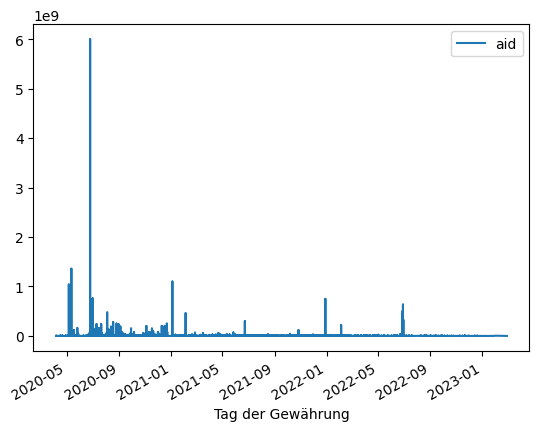

In [10]:
frame.plot(x="Tag der Gewährung", y=["aid"])

Show the sum for each aid instrument

In [ ]:
pd.options.display.float_format = "{:,.2f}".format
table_aid = frame.groupby('Beihilfeinstrument').sum().reset_index()#.to_latex()

In [216]:
table_aid

,Beihilfeinstrument,aid
0,Andere Formen der Kapitalintervention,"9,017,729,574.33"
1,Bürgschaft,"1,144,042,410.02"
2,Eigenkapitalinstrumente,"2,419,881,701.00"
3,Kredite/rückzahlbare Vorschüsse,"753,217,635.27"
4,Sonstiges (bitte angeben),"14,244,894,962.69"
5,Zinsgünstiges Darlehen,"10,500,942,385.00"
6,Zinszuschuss,"9,383,307,910.00"
7,Zuschuss,"24,959,647,770.34"


In [ ]:
with open('/Users/marco/Library/CloudStorage/OneDrive-HertieSchool/Thesis/GitHub/thesis/paper/Tables/table_1.tex', 'w') as tf:
     tf.write(table_aid.to_latex(index=False))

#### Timeline graph

In [ ]:
df_timeline = frame.groupby(["Tag der Gewährung",'Beihilfeinstrument']).sum().cumsum().reset_index().pivot_table(index='Tag der Gewährung', columns='Beihilfeinstrument')['aid'].reset_index()#.transpose().reset_index()

In [206]:
df_timeline.set_index('Tag der Gewährung', inplace=True)

In [207]:
df_timeline = df_timeline.fillna(method='ffill')

In [208]:
df_timeline = df_timeline.fillna(value=0)

In [ ]:
ax = df_timeline.plot(kind='area', alpha=.7, title="Foreign Holdings of U.S. Treasury short-term Debt",figsize=(10,5))
ax.set_xlabel("Timeline")
ax.invert_xaxis()
ax.set_ylabel("EUR")

#handles, labels = plt.gca().get_legend_handles_labels()
ax.legend( title='Group', loc='center left', bbox_to_anchor=(1, 0.5))

# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


plt.show()

In [37]:
df_timeline = frame.groupby(frame["Tag der Gewährung"].dt.strftime('%m-%y')).agg (total = ("aid" , 'sum')).reset_index().sort_values('Tag der Gewährung')

In [40]:
df_timeline['total'] = df_timeline['total'].cumsum()

<Axes: xlabel='Tag der Gewährung'>

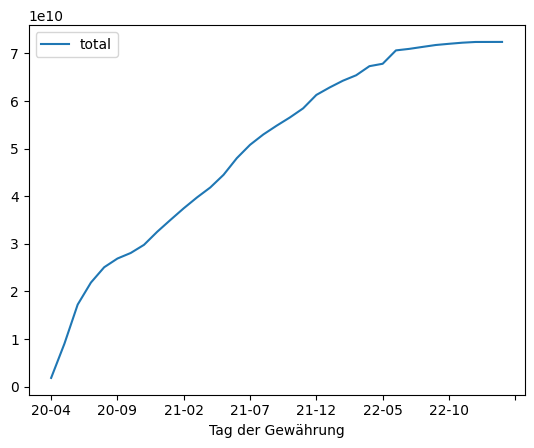

In [44]:
df_timeline.plot(x="Tag der Gewährung", y='total')

<Axes: xlabel='Tag der Gewährung'>

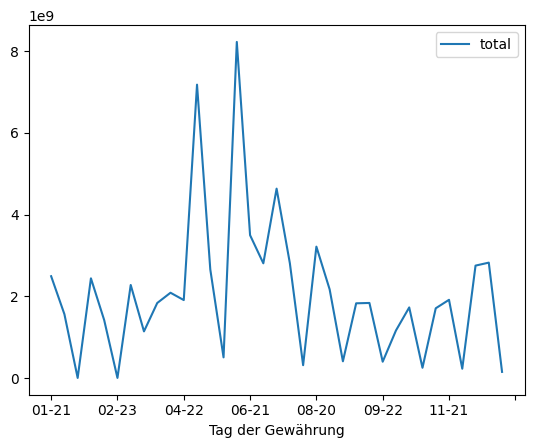

In [11]:
frame.groupby(frame["Tag der Gewährung"].dt.strftime('%m-%y')).agg (total = ("aid" , 'sum')).sort_index().plot()

In [15]:
frame.groupby(frame["Tag der Gewährung"].dt.strftime('%m-%y'))#.agg (total = ("Beihilfeelement, in voller Höhe" , 'sum'))

In [88]:
frame.to_csv(r'/Users/marco/Library/CloudStorage/OneDrive-HertieSchool/Thesis/GitHub/thesis/data/main/all_companies.csv', index=False, header=True)

In [155]:
frame = frame[['Name des Beihilfeempfängers','Nationale Kennung']].drop_duplicates()
frame = frame.reset_index(drop=True, names='index')
frame.index = frame.index.rename('Index')
frame['Status'] = ''
frame

,Name des Beihilfeempfängers,Nationale Kennung,Status
Index,,,
0,Eurocaribe Druck und Verlag GnbH,45/719/00411,
1,K-motion GmbH & Co. KG,43/637/00859,
2,Künstlermanagement Uwe Kanthak,48/635/01062,
3,Do it! Sprachreisen OHG,42/613/02646,
4,HCK Holding GmbH,48/747/06065,
...,...,...,...
102978,Milchproduktion Kreinitz GmbH,Betriebsnummer 6273600025,
102979,Jürgen Schirra,Betriebsnummer 072351140011,
102980,Milchproduktion Wildenborn KG,HRA 34143 Stendal,


In [159]:
frame.to_csv(r'/Users/marco/Library/CloudStorage/OneDrive-HertieSchool/Thesis/GitHub/thesis/data/main/companies.csv', sep='$' , index=True, header=True)